In [1]:
import os

total_epochs = ['1000000', '2500000', '5000000', '10000001', '15000000', '21000000']


def collect_subfolders(folder_path, prefix="BreakoutNoFrameskip-v4__alpha", alpha = '0.0'):
    subfolders = []

    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)
        if os.path.isdir(item_path) and item.startswith(prefix + alpha):
            subfolders.append(os.path.join(item_path, 'agent_0'))

    return subfolders

folder_path = "/data4/hop20001/ensemble_distil/cleanrl/runs/ppo_atari_consensus_total_time_"
subfolders_alpha_list = []
for epochs in total_epochs:
    subfolders_alpha_list.append(collect_subfolders(folder_path + epochs))


In [2]:
print(subfolders_alpha_list[0])

['/data4/hop20001/ensemble_distil/cleanrl/runs/ppo_atari_consensus_total_time_1000000/BreakoutNoFrameskip-v4__alpha0.0__seed1__1696463243/agent_0', '/data4/hop20001/ensemble_distil/cleanrl/runs/ppo_atari_consensus_total_time_1000000/BreakoutNoFrameskip-v4__alpha0.0__seed2__1696463590/agent_0', '/data4/hop20001/ensemble_distil/cleanrl/runs/ppo_atari_consensus_total_time_1000000/BreakoutNoFrameskip-v4__alpha0.0__seed3__1696463662/agent_0']


In [3]:
import os
import glob
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from scipy.interpolate import interp1d
import numpy as np


def extract_scalar_data(event_file, tag):
    event_acc = EventAccumulator(event_file)
    event_acc.Reload()
    data = event_acc.Scalars(tag)
    return data


def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

def smooth_data(data, window_size=15):
    x = [datum.step for datum in data]
    y = [datum.value for datum in data]
    
    # Smooth the curve using moving average
    y_smooth = moving_average(y, window_size)
    x_smooth = x[window_size - 1:]  # Adjust the x values to match the length of y_smooth
    
    # Interpolate the data points and distribute them evenly along the x-axis with an interval of 1
    x_new = np.arange(0, max(x_smooth), 100)
    interpolation_function = interp1d(x_smooth, y_smooth, kind='linear', fill_value="extrapolate")
    y_new = interpolation_function(x_new)
    
    return x_new, y_new

def smooth_data_multiple(data_list, window_size=25):
    x_max = max([datum.step for datum in data_list[0]])
    x_new = np.arange(0, x_max, 100)
    y_new_list = []

    for data in data_list:
        x = [datum.step for datum in data]
        y = [datum.value for datum in data]

        # Smooth the curve using moving average
        y_smooth = moving_average(y, window_size)
        x_smooth = x[window_size - 1:]  # Adjust the x values to match the length of y_smooth

        # Interpolate the data points
        interpolation_function = interp1d(x_smooth, y_smooth, kind='linear', fill_value="extrapolate")
        y_new = interpolation_function(x_new)
        y_new_list.append(y_new)

    # Average the y values among all data instances
    y_new_avg = np.mean(y_new_list, axis=0)

    return x_new, y_new_avg

def plot_data(x, y, title='charts/episodic_return'):
    plt.plot(x, y)
    plt.xlabel('Step')
    plt.ylabel('Value')
    plt.title(title)
    plt.show()

def plot_data_list(x_list, y_list, legends, title='charts/episodic_return'):
    for x, y, legend in zip(x_list, y_list, legends):
        plt.plot(x, y, label=legend)
    
    plt.xlabel('Step')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.show()

In [4]:
x_list = []
y_list = []
for subfolders_alpha in subfolders_alpha_list:
    event_files_list = []
    for tensorboard_file in subfolders_alpha:
        if os.path.isdir(tensorboard_file):
            event_files = glob.glob(os.path.join(tensorboard_file, 'events*'))
            if not event_files:
                raise ValueError(f"No event files found in the directory: {tensorboard_file}")
            event_file = event_files[0]
        else:
            event_file = tensorboard_file
        event_files_list.append(event_file)
    tag = 'charts/episodic_return'
    data_list = []
    for event_file in event_files_list:
        data = extract_scalar_data(event_file, tag)
        data_list.append(data)
    x, y = smooth_data_multiple(data_list)
    x_list.append(x)
    y_list.append(y)
# plot_data(x, y)

In [5]:
x_list[1]

array([      0,     100,     200, ..., 2497900, 2498000, 2498100])

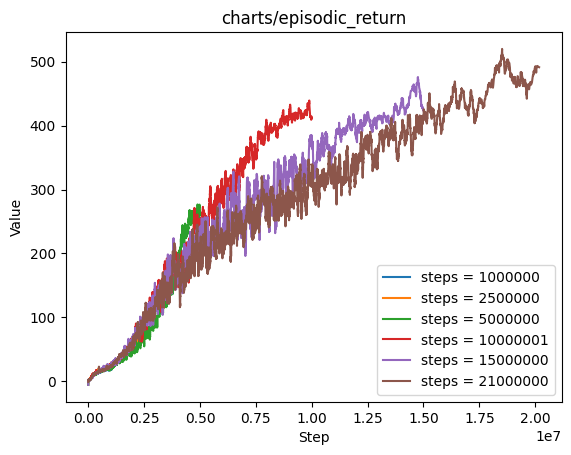

In [6]:
legends = [f'steps = {steps}' for steps in total_epochs]
plot_data_list(x_list, y_list, legends)

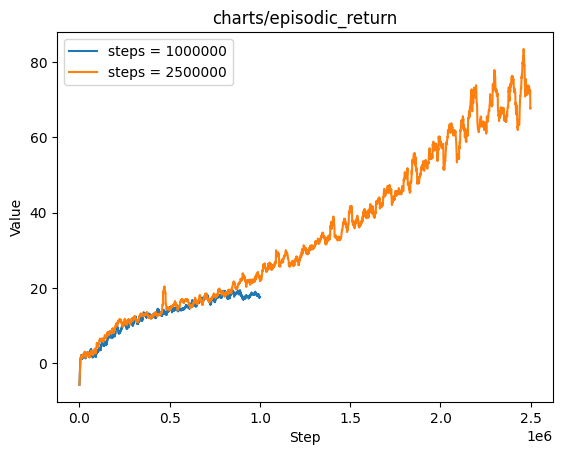

In [10]:
plot_data_list(x_list[0:2], y_list[0:2], legends[0:2])